## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats 

## Получение данных

In [2]:
hypo = pd.read_csv('/datasets/hypothesis.csv')
pd.options.display.max_colwidth = 100
hypo

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [3]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [4]:
orders = pd.read_csv('/datasets/orders.csv')
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Данные загрузились успешно
## Оценка и предобработка данных

In [5]:
visitors.info()
print()
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Пропуски отсутствуют. Необходимо изменить тип данных в колонке 'date' в обоих наборах данных.

In [6]:
visitors['date'] = pd.to_datetime(
    visitors['date'],
    format = '%Y-%m-%d'
)
orders['date'] = pd.to_datetime(
    orders['date'],
    format = '%Y-%m-%d'
)

Количество посетителей в группах A и B должно быть одинаковым либо не отличаться более, чем на 1 %

In [7]:
if (visitors[visitors['group'] == 'A']['visitors'].sum()) == (visitors[
    visitors['group'] == 'B']['visitors'].sum()):
    print('Деление на группы равномерное')
else:
    print('Деление на группы неравномерное, относительная разница (A-B)/A = {:.2%}'.format(
    (visitors[
        visitors['group'] == 'A']['visitors'].sum() - visitors[
        visitors['group'] == 'B']['visitors'].sum()) / visitors[
        visitors['group'] == 'A']['visitors'].sum()))

Деление на группы неравномерное, относительная разница (A-B)/A = -0.96%


Разница не превышает 1,0 %, принимается, что группы формируются относительно равномерно 

In [8]:
B_buyer = orders[orders['group'] == 'B']['visitorId'].value_counts().index
A_buyer = orders[orders['group'] == 'A']['visitorId'].value_counts().index
len(A_buyer[A_buyer.isin(B_buyer)])

58

58 пользователей группы A совершали покупки, находясь и в группе B. Например, пользователь 4256040402:

In [9]:
orders[orders['visitorId'] == 4256040402].sort_values(by = 'date')

,transactionId,visitorId,date,revenue,group
114,1120327437,4256040402,2019-08-01,5800,A
873,2519737434,4256040402,2019-08-08,58220,B
1091,750632879,4256040402,2019-08-12,50,A
60,1421016313,4256040402,2019-08-16,56650,B
187,2048878902,4256040402,2019-08-17,1550,A
263,2575861846,4256040402,2019-08-18,10970,B
588,3700356838,4256040402,2019-08-20,17650,A
253,1610091760,4256040402,2019-08-23,16950,A
901,3402467119,4256040402,2019-08-27,1630,A
1018,1415970216,4256040402,2019-08-31,5170,A


Одни и те же пользователи, совершавшие покупки в разных группах, серьезно исказят результаты последующего анализа. Вряд ли их удаление значительно увеличит ценность теста, но по меньшей мере данные будут соответствовать условиям успешного A/B-тестирования. Создается новый датасет, не содержащий записи о покупках пользователей обоих групп.  

In [10]:
orders_proved = orders[~orders['visitorId'].isin(A_buyer[A_buyer.isin(B_buyer)])]
orders_proved.info()
print()
print('Потеряно', orders.shape[0] - orders_proved.shape[0],'записи(ей)')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1016 non-null int64
visitorId        1016 non-null int64
date             1016 non-null datetime64[ns]
revenue          1016 non-null int64
group            1016 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB

Потеряно 181 записи(ей)


## Приоритезация гипотез
### Фреймворк ICE 

In [11]:
# ICE_score = Impact x Confidence x Ease; Ease = 1 / Efforts
hypo['ICE_score'] = (hypo['Impact'] * hypo['Confidence'] / hypo['Efforts']).round(1) 
hypo[['Hypothesis','ICE_score']].sort_values(by = 'ICE_score', ascending = False).reset_index()

,index,Hypothesis,ICE_score
0,8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
1,0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
2,7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
3,6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",8.0
4,2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",7.0
5,1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
6,5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
7,3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
8,4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


Без учета охватываемой аудитории гипотеза о введении акции ко дню рождения лидирует в приоритетном списке. В первой тройке также организация 2 новых каналов и добавление формы подписки.
В масс-маркетинге важно учитывать кол-во аудитории ее охват предполагаемым изменением. Требуется рассчитать показатель RICE
### Фреймворк RICE

In [12]:
# RICE_score = (Reach x Impact x Confidence) / Efforts
hypo['RICE_score'] = (hypo['Reach'] * hypo['Impact'] * hypo['Confidence']) / hypo['Efforts']
hypo[['Hypothesis','RICE_score']].sort_values(by = 'RICE_score', ascending = False).reset_index() 

,index,Hypothesis,RICE_score
0,7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
1,2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",56.0
2,0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
3,6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",40.0
4,8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
5,3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
6,1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
7,5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
8,4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


С учетом охвата аудитории сайта, поменялось положение гипотез в приоритетном списке. Значительно превосходит остальные гипотеза о добавлении формы подписки на все основные страницы сайта. Эта же гипотеза было в списке 3 лучших гипотез по подсчету в фреймворке ICE.
### Выводы
С учетом аудитории, наиболее приоритетной для проведения A/B-теста в результате оценки является гипотеза "Добавить форму подписки на основные страницы, чтобы собрать базу клиентов для e-mail-рассылок", однако ее формулировка некорректна, так как отсутствует описание ожидаемого результата - увеличение конверсии/среднего чека/и т.д, поэтому выбирается другая гипотеза, а именно:

<font color='green'><b>Увеличение конверсии и среднего чека в результате добавления блоков рекомендаций</b></font>

## Анализ A/B-теста
### Подготовка данных

In [13]:
# посетители: деление по группам
visitors_A_daily = visitors[visitors['group'] == 'A'][['date','visitors']]
visitors_B_daily = visitors[visitors['group'] == 'B'][['date','visitors']]

# переименование столбцов
visitors_A_daily.columns = ['date','A_visitors']
visitors_B_daily.columns = ['date','B_visitors']

# кумулятивные данные по посещениям
visitors_A_cumm = visitors_A_daily.apply(
    lambda x: visitors_A_daily[visitors_A_daily['date'] < x['date']].agg({
        'date':'max',
        'A_visitors':'sum'
    }), axis = 1)

visitors_B_cumm = visitors_B_daily.apply(
    lambda x: visitors_B_daily[visitors_B_daily['date'] < x['date']].agg({
        'date':'max',
        'B_visitors':'sum'
    }), axis = 1    
)

# переименование столбцов
visitors_A_cumm.columns = ['date','cumm_A_visitors']
visitors_B_cumm.columns = ['date','cumm_B_visitors']

In [14]:
visitors_A_cumm.head(7)

,date,cumm_A_visitors
0,NaT,0
1,2019-08-01,719
2,2019-08-02,1338
3,2019-08-03,1845
4,2019-08-04,2562
5,2019-08-05,3318
6,2019-08-06,3985


In [15]:
# заказы: деление по группам
orders_A_daily = orders_proved[orders_proved['group'] == 'A'].groupby(
    'date', as_index = False).agg({
    'transactionId':pd.Series.nunique,
    'revenue':'sum'
    })

orders_B_daily = orders_proved[orders_proved['group'] == 'B'].groupby(
    'date', as_index = False).agg({
    'transactionId':pd.Series.nunique,
    'revenue':'sum'
})

# переименование столбцов
orders_A_daily.columns = ['date','A_orders_per_date','A_revenue_per_date']
orders_B_daily.columns = ['date','B_orders_per_date','B_revenue_per_date']

# кумулятивные данные по заказам
orders_A_cumm = orders_A_daily.apply(lambda x:
                                    orders_A_daily[orders_A_daily['date'] < x['date']].agg({
    'date':'max',
    'A_orders_per_date':'sum',
    'A_revenue_per_date':'sum'
}), axis = 1).sort_values('date')

orders_B_cumm = orders_B_daily.apply(lambda x:
                                    orders_B_daily[orders_B_daily['date'] < x['date']].agg({
    'date':'max',
    'B_orders_per_date':'sum',
    'B_revenue_per_date':'sum'
}), axis = 1).sort_values('date')

# переименование столбцов

orders_A_cumm.columns = ['date', 'A_orders_cumm', 'A_revenue_cumm']
orders_B_cumm.columns = ['date', 'B_orders_cumm', 'B_revenue_cumm']

In [16]:
orders_A_cumm.head(7)

,date,A_orders_cumm,A_revenue_cumm
1,2019-08-01,23,142779
2,2019-08-02,42,234381
3,2019-08-03,66,346854
4,2019-08-04,77,388030
5,2019-08-05,99,474413
6,2019-08-06,114,515332
7,2019-08-07,130,638580


In [17]:
orders_A_daily.head(7)

,date,A_orders_per_date,A_revenue_per_date
0,2019-08-01,23,142779
1,2019-08-02,19,91602
2,2019-08-03,24,112473
3,2019-08-04,11,41176
4,2019-08-05,22,86383
5,2019-08-06,15,40919
6,2019-08-07,16,123248


In [18]:
data = orders_A_daily.merge(orders_B_daily, on = 'date', how = 'left' ).merge(
    orders_A_cumm, on = 'date', how = 'left').merge(
    orders_B_cumm, on = 'date', how = 'left').merge(
    visitors_A_daily, on = 'date', how = 'left').merge(
    visitors_B_daily, on = 'date', how = 'left').merge(
    visitors_A_cumm, on = 'date', how = 'left').merge(
    visitors_B_cumm, on = 'date', how = 'left')
data['date_m_d'] = data['date'].dt.strftime('%d-%m')
data.head(5)

,date,A_orders_per_date,A_revenue_per_date,B_orders_per_date,B_revenue_per_date,A_orders_cumm,A_revenue_cumm,B_orders_cumm,B_revenue_cumm,A_visitors,B_visitors,cumm_A_visitors,cumm_B_visitors,date_m_d
0,2019-08-01,23,142779,17,59758,23.0,142779.0,17.0,59758.0,719,713,719.0,713.0,01-08
1,2019-08-02,19,91602,23,162043,42.0,234381.0,40.0,221801.0,619,581,1338.0,1294.0,02-08
2,2019-08-03,24,112473,14,67049,66.0,346854.0,54.0,288850.0,507,509,1845.0,1803.0,03-08
3,2019-08-04,11,41176,14,96890,77.0,388030.0,68.0,385740.0,717,770,2562.0,2573.0,04-08
4,2019-08-05,22,86383,21,89908,99.0,474413.0,89.0,475648.0,756,707,3318.0,3280.0,05-08


### Кумулятивная выручка по группам

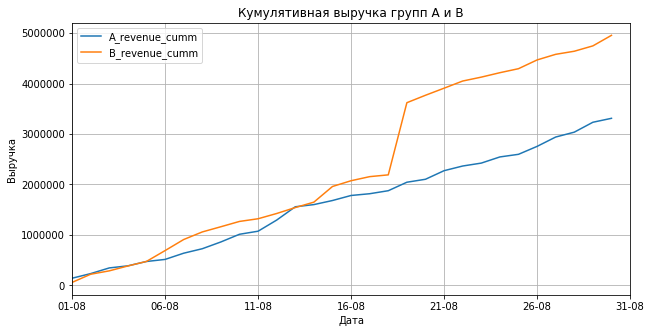

In [19]:
data.plot(
    x = 'date_m_d',
    y = ['A_revenue_cumm','B_revenue_cumm'],
    grid = True,
    legend = True,
    title = 'Кумулятивная выручка групп А и B',
    figsize=(10,5)
)
plt.xlabel('Дата')
plt.ylabel('Выручка');

В первую неделю августа кумулятивная выручка обеих групп находилась практически на одном уровне. Уже к концу первой недели наметились преобладание выручки группы B над группой А. Значительное расхождение оформилось середине первой - начале второй декады августа, а 19 августа отрыв группы B значительно увеличился за счет одной аномальной покупки.

Для корректной оценки покупка 19 августа должна быть отфильтрована.
### График кумулятивного среднего чека

Text(0.5, 0, 'Дата')

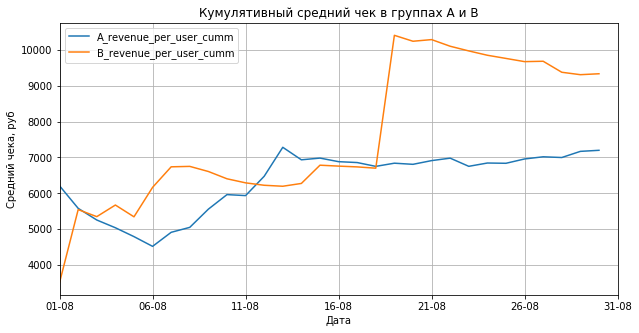

In [20]:
data['A_revenue_per_user_cumm'] = data['A_revenue_cumm'] / data['A_orders_cumm']
data['B_revenue_per_user_cumm'] = data['B_revenue_cumm'] / data['B_orders_cumm']
data.plot(
    x = 'date_m_d',
    y = ['A_revenue_per_user_cumm','B_revenue_per_user_cumm'],
    grid = True,
    legend = True,
    title = 'Кумулятивный средний чек в группах А и В',
    figsize = (10,5)
    );
plt.ylabel('Средний чека, руб')
plt.xlabel('Дата')

Аналогично ситуации на графике кумулятивной выручки, на графике кумулятивного среднего чека наблюдяется резкий рост значения 19 августа в группе B. К концу месяца средний чек в группе B несколько уменьшился, но оставался значительно большим, чем в группе A. 

В конце месяца метрики не подвергаются значительным колебаниям, как в начале месяца.
### График кумулятивного среднего чека группы B к чеку группы A

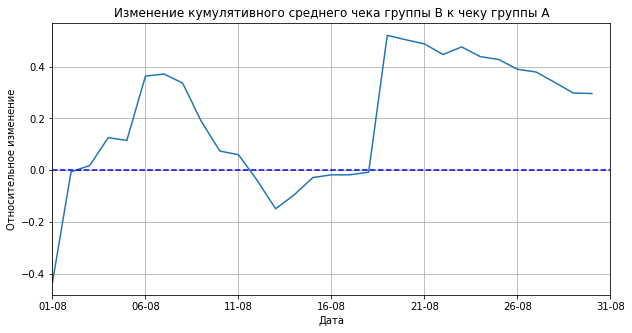

In [21]:
data['BvsA_revenue_per_user_cumm'] = (
    data['B_revenue_per_user_cumm'] / data['A_revenue_per_user_cumm']) - 1
data.plot(
    x = 'date_m_d',
    y = 'BvsA_revenue_per_user_cumm',
    grid = True,
    legend = False,
    title = 'Изменение кумулятивного среднего чека группы В к чеку группы А',
    figsize = (10,5)
)
plt.axhline(y = 0, color = 'blue', linestyle = '--')
plt.ylabel('Относительное изменение')
plt.xlabel('Дата');

Относительное значение среднего чека группы B к чеку группы A в первой половине месяца подвержено серьезным колебаниям. Аномальная покупка 19 августа также отразилась и на этом графике. Без учета этой покупки, вероятно, к концу месяца средний чек группы B был бы ниже среднего чека группы A, так как после 19 августа наблюдается тенденция к снижению значения.
### График кумулятивной конверсии по группам

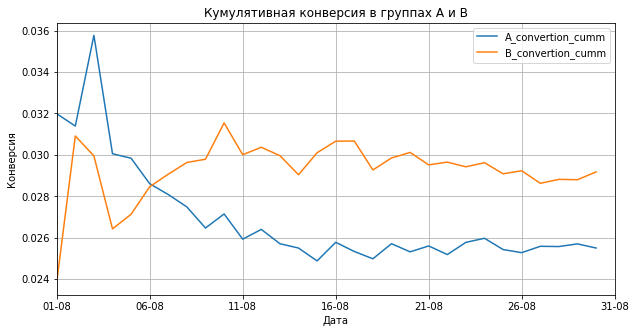

In [22]:
data['A_convertion_cumm'] = data['A_orders_cumm'] / data['cumm_A_visitors']
data['B_convertion_cumm'] = data['B_orders_cumm'] / data['cumm_B_visitors']
data.plot(
    x = 'date_m_d',
    y = ['A_convertion_cumm','B_convertion_cumm'],
    grid = True,
    legend = True,
    figsize = (10,5),
    title = 'Кумулятивная конверсия в группах A и B'
)
plt.ylabel('Конверсия')
plt.xlabel('Дата');

К концу месяца показатели стабилизировались. Конверсия в группе B больше примерно на 0,3 %
### График отн. изменения кумулятивной конверсии группы B к конверсии А

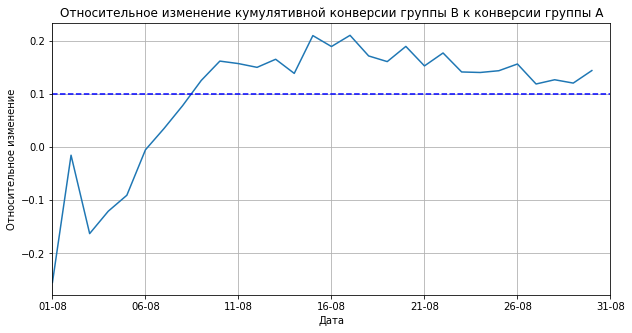

In [23]:
data['BvsA_convertion_cumm'] = (
    data['B_convertion_cumm'] / data['A_convertion_cumm']) - 1
data.plot(
    x = 'date_m_d',
    y = 'BvsA_convertion_cumm',
    legend = False,
    grid = True,
    figsize = (10,5),
    title = 'Относительное изменение кумулятивной конверсии группы B к конверсии группы A'
)
plt.ylabel('Относительное изменение')
plt.xlabel('Дата')
plt.axhline(y = 0.1, color = 'blue', linestyle = '--');

Относительная конверсия в группе B по отношению к группе A к концу месяца зафиксировалась на уровне 0,1, т.е в целом конверсия в группе B более чем на 10 % больше конверсии в группе A.
### Количество заказов по пользователям

In [24]:
orders_by_users = orders[['visitorId','transactionId']].groupby(
    'visitorId', as_index = False)['transactionId'].count().reset_index()
orders_by_users.columns = ['number','user_id','orders_quantity']
orders_by_users.sort_values(by='orders_quantity', ascending = False).head(5)

,number,user_id,orders_quantity
1023,1023,4256040402,11
591,591,2458001652,11
569,569,2378935119,9
487,487,2038680547,8
44,44,199603092,5


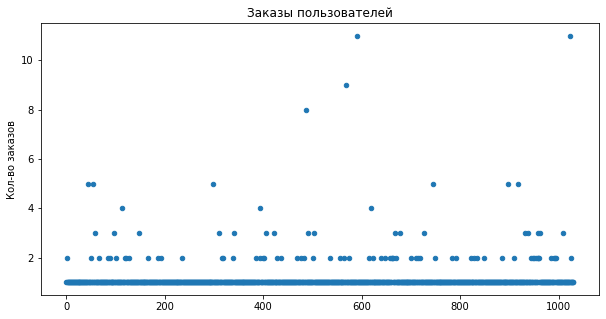

In [25]:
orders_by_users.plot(
    kind = 'scatter',
    x = 'number',
    y = 'orders_quantity',
    title = 'Заказы пользователей',
    figsize=(10,5)
);
plt.ylabel('Кол-во заказов')
plt.xlabel('');

Большинство пользователей в течение периода наблюдения совершали 1 покупку, реже - 2. Лишь единицы совершали более 3 покупок.

### Перцентили заказов на пользователя

In [26]:
np.percentile(orders_by_users['orders_quantity'], [95,99])
orders_lim = 3

5 % пользователей заказывают более 2 раз, 1 % пользователей заказывают более 4 раз. За границу для определения аномального количества заказов принимается 3 заказа на пользователя 
### График стоимостей заказов

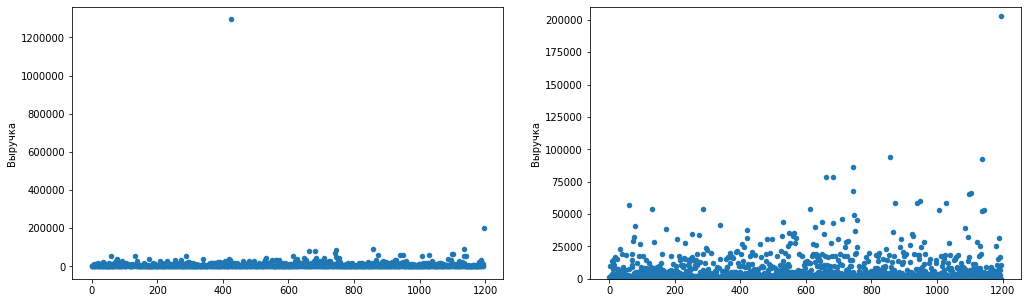

In [27]:
orders['x_values'] = range(0,len(orders)) 
plt.subplots(figsize = (17,5))
plot = orders.plot(
    kind = 'scatter',
    x = 'x_values',
    y = 'revenue',
    ax = plt.subplot(1,2,1)
)
plt.xlabel('')
plt.ylabel('Выручка');
plot = orders.plot(
    kind = 'scatter',
    x = 'x_values',
    y = 'revenue',
    ax = plt.subplot(1,2,2)
)
plt.xlabel('')
plt.ylabel('Выручка')
plt.ylim(0,210000);

Большая часть заказов приносит выручку в размере, не превышающем 25 000 рублей (видно на графике справа). Наблюдаются два резко аномальных значения: одно в размере, превышающем 1 млн.рублей, другое около 200 000 тыс.рублей.
### Перцентили выручки от заказа

In [28]:
np.percentile(orders['revenue'], [95,99])
revenue_lim = 50000

5 % пользователей совершают заказы стоимостью более 28 т.р, а 1 % пользователей - более 58 т.р.
С учетом графика, граница для определения аномальных заказов опеределена как 50 000 р.  
### Статистическая значимость различий в конверсии между группами
Проводится по "сырым" данным, т.е с учетом аномальных значений числа и стоимости покупок

In [29]:
# список пользователей, совершавших заказы, с количеством их заказов
orders_A_users = orders[orders['group'] == 'A'].groupby(
    'visitorId', as_index = False).agg({'transactionId' : pd.Series.nunique})
orders_B_users = orders[orders['group'] == 'B'].groupby(
    'visitorId', as_index = False).agg({'transactionId' : pd.Series.nunique})

#переименование столбцов
orders_A_users.columns = ['user_id','orders_quantity']
orders_B_users.columns = ['user_id','orders_quantity']

# списки соответствия 'пользователь - кол-во заказов' для всех пользователей в каждой группе

sample_A = pd.concat([
    orders_A_users['orders_quantity'],
    pd.Series(0, index = np.arange(data['A_visitors'].sum() - len(
        orders_A_users['orders_quantity'])),
              name = 'orders_quantity')], axis = 0)

sample_B = pd.concat([
    orders_B_users['orders_quantity'],
    pd.Series(0, index = np.arange(data['B_visitors'].sum() - len(
        orders_B_users['orders_quantity'])),
              name = 'orders_quantity')], axis = 0)

После подготовки данных применяется критерий Манна-Уитни.

Критерий значимости 0,05

In [30]:
print('p-value критерия Манна-Уитни: {:.3f}'.format(stats.mannwhitneyu(
    sample_A,
    sample_B)[1]))
print('Относительный прирост конверсии группы B к конверсии группы A: {:.1%}'.format(
    sample_B.mean()/sample_A.mean() - 1))

p-value критерия Манна-Уитни: 0.008
Относительный прирост конверсии группы B к конверсии группы A: 13.8%


Конверсия группы B по сравнению с конверсией группы A увеличилась почти на 15 %. 

Увеличение является статистически значимым. Проведено сравнение сырых данных, без исключения выбросов.
### Статистическая значимость различий размера среднего чека групп A и B
Сравнение производится по "сырым" данным

Уровень значимости 5 %

In [31]:
print('p-value критерия Манна-Уитни: {:.3f}'.format(
    stats.mannwhitneyu(
        orders[orders['group'] == 'A']['revenue'],
        orders[orders['group'] == 'B']['revenue']
    )[1]))

print('Относительный прирост среднего чека группы B к среднему чеку A: {:.1%}'.format(
    orders[orders['group'] == 'B']['revenue'].mean() / orders[
        orders['group'] == 'A']['revenue'].mean() - 1)
     )

p-value критерия Манна-Уитни: 0.365
Относительный прирост среднего чека группы B к среднему чеку A: 25.9%


p-value значительно выше уровня значимости: статистически значимого различия значения среднего чека в группах A и B нет, хотя значение к группе B и выше, чем в группе A, вероятно, за счет обнаруженной ранее аномальной покупки (19 августа):

In [32]:
orders[np.logical_and(orders['date'] == '2019-08-19',
                      orders['revenue'] > 100000)]

,transactionId,visitorId,date,revenue,group,x_values
425,590470918,1920142716,2019-08-19,1294500,B,425


### Различие в конверсии между группами по "очищенным" данным

Ранее была выявлена аномальная покупка в группе B, принесшая выручку в размере 1 294 500 рублей. Этот, а также другие выбросы, оказывают сильное влияние на результаты применения статистических критерия, а также на кумулятивные метрики.

Ранее были определены границы, отделяющие аномальные значения:
- по кол-ву покупок - не более 3;
- по сумме выручки с заказа - не более 50 000 р.

"Аномальные" пользователи выделяются в отдельную группу

In [33]:
# часто покупающие пользователи
users_often_buying = pd.concat([
    orders_A_users[orders_A_users['orders_quantity'] > orders_lim]['user_id'],
    orders_B_users[orders_B_users['orders_quantity'] > orders_lim]['user_id']
], axis = 0) 

# много покупающие пользователи

users_expensive_buying = orders[orders['revenue'] > revenue_lim]['visitorId']

# "аномальные пользователи"

abnormal_users = pd.concat([
    users_often_buying,
    users_expensive_buying
], axis = 0).drop_duplicates().sort_values()

print('Кол-во аномальных пользователей: ', len(abnormal_users))

Кол-во аномальных пользователей:  26


Подготовка отфильтрованных от выбросов данных:

In [34]:
sample_A_filtered = pd.concat([
    orders_A_users[~orders_A_users['user_id'].isin(abnormal_users)]['orders_quantity'],
    pd.Series(0, index = np.arange(data['A_visitors'].sum() - len(
        orders_A_users[~orders_A_users['user_id'].isin(abnormal_users)])),
              name = 'orders_quantity')], axis = 0)

sample_B_filtered = pd.concat([
    orders_B_users[~orders_B_users['user_id'].isin(abnormal_users)]['orders_quantity'],
    pd.Series(0, index = np.arange(data['B_visitors'].sum() - len(
        orders_B_users[~orders_B_users['user_id'].isin(abnormal_users)])),
             name = 'orders_quantity')], axis = 0)

In [35]:
print('p-value критерия Манна-Уитни: {:.3f}'.format(stats.mannwhitneyu(
    sample_A_filtered,
    sample_B_filtered)[1]))
print('Относительный прирост конверсии группы B к конверсии группы A: {:.1%}'.format(
    sample_B_filtered.mean()/sample_A_filtered.mean() - 1))

p-value критерия Манна-Уитни: 0.006
Относительный прирост конверсии группы B к конверсии группы A: 15.8%


Уровень статистической значимости 0,05

После очистки данных от аномальных пользователей, сохраняется статистическая значимость роста конверсии в группе B в сравнении с конверсией в группе A на уровне 15 %. 
### Различие величины среднего чека между группами по "очищенным" данным
Уровень статистической значимости 0,05

In [36]:
print('p-value критерия Манна-Уитни: {:.3f}'.format(
    stats.mannwhitneyu(
        orders[np.logical_and(
            orders['group'] == 'A',
            np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'],
        orders[np.logical_and(
            orders['group'] == 'B',
            np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue']
    )[1]))

print('Относительный прирост среднего чека группы B к среднему чеку A: {:.1%}'.format(
    orders[np.logical_and(
        orders['group'] == 'B',
        np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'].mean() / orders[
        np.logical_and(orders['group'] == 'A',
                       np.logical_not(
                           orders['visitorId'].isin(abnormal_users)))]['revenue'].mean() - 1)
     )

p-value критерия Манна-Уитни: 0.409
Относительный прирост среднего чека группы B к среднему чеку A: 2.4%


После удаления выбросов, различие значений среднего чека в группах также статистически незначимое, а величина относительного прироста чека группы B к чеку группы A скорретировалась до 2,4 %.

## Выводы
Проверялась гипотеза об увеличении конверсии и среднего чека в результате добавления блоков рекомендаций.

Перед формированием выводов следует обратить внимание на следующее:
1. Часть гипотез сформулирована некорректно. Необходимо четко обозначить тестируемое изменение и определить его следствия в виде изменения метрик до приоритезации гипотез.
2. Следует обратить внимание на качество проведенного A/B-теста: в данных 58 пользователей совершали покупки, находясь как в группе A, так и в группе B

В результате анализа данных A/B-теста выявлено:
1. Статистически значимый прирост конверсии в исследуемой группе в сравнении с контрольной на уровне 15 %;
2. Отсутствие статистически значимого прироста величины среднего чека в исследуемой группе в сравнении с контрольной. Рост к концу месяца, при удалении выбросов, составляет около 2 %.
3. Графики абсолютных и относительных метрик стабилизировались только к концу месяца, т.е на данный момент говорить о фиксации результата преждевременно. 

Следует продолжить тест еще в течение недели. 

<b>Предварительные выводы таковы:</b> добавление блоков рекомендаций приводит к росту конверсии. Размер среднего чека при этом не изменяется.